# 02 - GNN Baseline Model

Train a Graph Neural Network (GraphSAGE) baseline for fraud detection on the Elliptic Bitcoin dataset.

**Objectives:**
1. Load and prepare the graph data
2. Build and train GraphSAGE model
3. Evaluate performance (Precision, Recall, F1, AUC)
4. Save model checkpoint for RAG pipeline

## 1. Setup & Imports

In [1]:
import sys
sys.path.append('..')

import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, f1_score
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 2. Load Data

In [4]:
# Reload modules to pick up any changes
import importlib
import src.data.elliptic_loader
import src.data.graph_builder
importlib.reload(src.data.elliptic_loader)
importlib.reload(src.data.graph_builder)

from src.data.graph_builder import GraphBuilder

# Build PyG graph directly (handles loading internally)
data_path = '../data/elliptic_bitcoin_dataset'
builder = GraphBuilder(data_path)
data = builder.build()

print(f"\nGraph Statistics:")
print(f"  Nodes: {data.num_nodes:,}")
print(f"  Edges: {data.num_edges:,}")
print(f"  Features per node: {data.num_node_features}")

Loading Elliptic dataset...
  Features: 203,769 nodes, 167 columns
  Labels: 203,769 entries
  Edges: 234,355 directed edges
  Node mapping: 203,769 unique nodes
  Normalizing features...
  Features shape: (203769, 166)
  Time steps: 1 to 49 (49 unique)
  Label distribution:
    unknown: 157,205 (77.15%)
    licit: 42,019 (20.62%)
    illicit: 4,545 (2.23%)
  Edge index shape: (2, 234355)

Temporal splits:
  Train: 34 time steps, 136,265 nodes (29,894 labeled)
  Val:   7 time steps, 30,680 nodes (7,829 labeled)
  Test:  8 time steps, 36,824 nodes (8,841 labeled)

Class weights: licit=0.5541, illicit=5.1226

PyG Data Object Created
Nodes: 203,769
Edges: 234,355
Features: 166
Train nodes: 29,894
Val nodes: 7,829
Test nodes: 8,841

Graph Statistics:
  Nodes: 203,769
  Edges: 234,355
  Features per node: 166


In [5]:
# Check class distribution for labeled nodes
labeled_mask = data.y != -1  # -1 = unknown
labels = data.y[labeled_mask]

illicit = (labels == 1).sum().item()
licit = (labels == 0).sum().item()
unknown = (data.y == -1).sum().item()

print(f"Label Distribution:")
print(f"  Illicit (1): {illicit:,} ({illicit/(illicit+licit)*100:.1f}%)")
print(f"  Licit (0): {licit:,} ({licit/(illicit+licit)*100:.1f}%)")
print(f"  Unknown (-1): {unknown:,}")
print(f"\nClass imbalance ratio: 1:{licit/illicit:.1f}")

Label Distribution:
  Illicit (1): 4,545 (9.8%)
  Licit (0): 42,019 (90.2%)
  Unknown (-1): 157,205

Class imbalance ratio: 1:9.2


## 3. Train/Val/Test Split

Using temporal split based on timesteps (more realistic for production).

In [6]:
# GraphBuilder already created temporal splits - let's verify
print(f"Train: {data.train_mask.sum().item():,} nodes")
print(f"Val: {data.val_mask.sum().item():,} nodes")
print(f"Test: {data.test_mask.sum().item():,} nodes")

Train: 29,894 nodes
Val: 7,829 nodes
Test: 8,841 nodes


In [7]:
# Verify class distribution in each split
for name, mask in [('Train', data.train_mask), ('Val', data.val_mask), ('Test', data.test_mask)]:
    split_labels = data.y[mask]
    illicit_count = (split_labels == 1).sum().item()
    licit_count = (split_labels == 0).sum().item()
    total = illicit_count + licit_count
    print(f"{name}: {illicit_count} illicit ({illicit_count/total*100:.1f}%), {licit_count} licit ({licit_count/total*100:.1f}%)")

Train: 3462 illicit (11.6%), 26432 licit (88.4%)
Val: 675 illicit (8.6%), 7154 licit (91.4%)
Test: 408 illicit (4.6%), 8433 licit (95.4%)


## 4. Build GraphSAGE Model

In [8]:
from src.models.graphsage import GraphSAGEModel

# Model configuration
model = GraphSAGEModel(
    num_features=data.num_node_features,
    num_classes=2,
    hidden_dims=[256, 128],
    embedding_dim=64,
    dropout=0.3,
    use_batch_norm=True
).to(device)

print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

GraphSAGEModel(
  (convs): ModuleList(
    (0): SAGEConv(166, 256, aggr=mean)
    (1): SAGEConv(256, 128, aggr=mean)
  )
  (batch_norms): ModuleList(
    (0): BatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (embedding_layer): SAGEConv(128, 64, aggr=mean)
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

Total parameters: 168,258


## 5. Training Setup

In [9]:
# Move data to device
data = data.to(device)

# Class weights for imbalanced data
train_labels = data.y[data.train_mask]
n_illicit = (train_labels == 1).sum().item()
n_licit = (train_labels == 0).sum().item()

# Inverse frequency weighting
weight_illicit = n_licit / n_illicit
class_weights = torch.tensor([1.0, weight_illicit], device=device)
print(f"Class weights: [licit: 1.0, illicit: {weight_illicit:.2f}]")

# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10)

Class weights: [licit: 1.0, illicit: 7.63]


In [10]:
def train_epoch(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    
    logits, _ = model(data.x, data.edge_index)
    loss = criterion(logits[data.train_mask], data.y[data.train_mask])
    
    loss.backward()
    optimizer.step()
    
    return loss.item()


@torch.no_grad()
def evaluate(model, data, mask):
    model.eval()
    
    logits, embeddings = model(data.x, data.edge_index)
    probs = F.softmax(logits, dim=1)
    preds = logits.argmax(dim=1)
    
    y_true = data.y[mask].cpu().numpy()
    y_pred = preds[mask].cpu().numpy()
    y_prob = probs[mask, 1].cpu().numpy()
    
    # Metrics
    f1 = f1_score(y_true, y_pred, average='binary', pos_label=1)
    
    try:
        auc = roc_auc_score(y_true, y_prob)
    except:
        auc = 0.0
    
    return {
        'f1': f1,
        'auc': auc,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_prob': y_prob
    }

## 6. Training Loop

In [11]:
# Training configuration
NUM_EPOCHS = 200
PATIENCE = 30
best_val_f1 = 0
patience_counter = 0

# History
history = {
    'train_loss': [],
    'val_f1': [],
    'val_auc': []
}

print("Starting training...\n")

for epoch in tqdm(range(NUM_EPOCHS), desc="Training"):
    # Train
    loss = train_epoch(model, data, optimizer, criterion)
    
    # Evaluate
    val_metrics = evaluate(model, data, data.val_mask)
    
    # Record history
    history['train_loss'].append(loss)
    history['val_f1'].append(val_metrics['f1'])
    history['val_auc'].append(val_metrics['auc'])
    
    # Learning rate scheduling
    scheduler.step(val_metrics['f1'])
    
    # Early stopping check
    if val_metrics['f1'] > best_val_f1:
        best_val_f1 = val_metrics['f1']
        patience_counter = 0
        # Save best model
        best_model_state = model.state_dict().copy()
    else:
        patience_counter += 1
    
    # Print progress every 20 epochs
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1:3d} | Loss: {loss:.4f} | Val F1: {val_metrics['f1']:.4f} | Val AUC: {val_metrics['auc']:.4f}")
    
    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

print(f"\nBest validation F1: {best_val_f1:.4f}")

Starting training...



Training:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch  20 | Loss: 0.2466 | Val F1: 0.3504 | Val AUC: 0.9143

Early stopping at epoch 36

Best validation F1: 0.4199


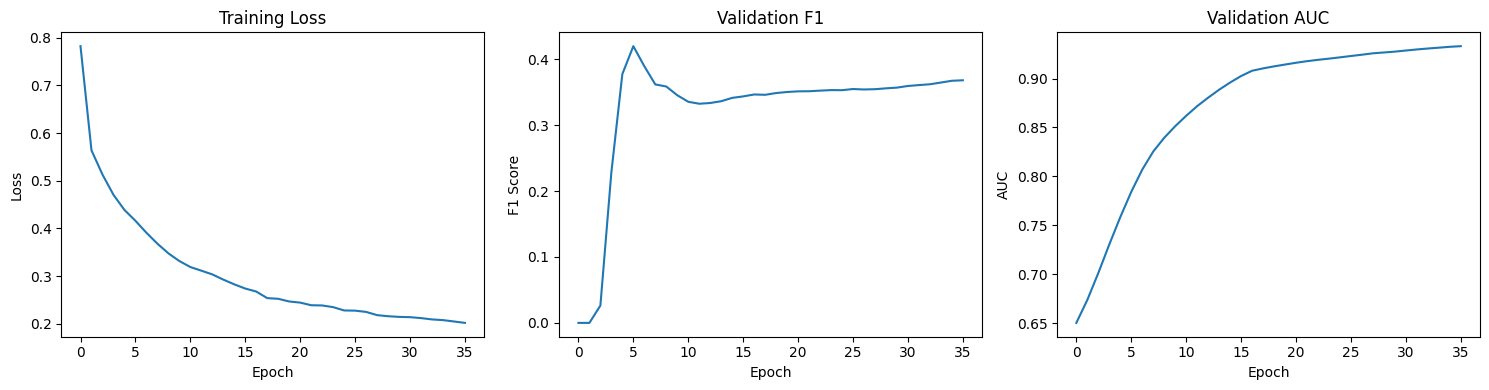

In [12]:
# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(history['train_loss'])
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')

axes[1].plot(history['val_f1'])
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('F1 Score')
axes[1].set_title('Validation F1')

axes[2].plot(history['val_auc'])
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('AUC')
axes[2].set_title('Validation AUC')

plt.tight_layout()
plt.show()

## 7. Final Evaluation on Test Set

In [13]:
# Load best model
model.load_state_dict(best_model_state)

# Evaluate on test set
test_metrics = evaluate(model, data, data.test_mask)

print("=" * 50)
print("TEST SET RESULTS")
print("=" * 50)
print(f"\nF1 Score: {test_metrics['f1']:.4f}")
print(f"AUC-ROC:  {test_metrics['auc']:.4f}")

print("\nClassification Report:")
print(classification_report(
    test_metrics['y_true'], 
    test_metrics['y_pred'],
    target_names=['Licit', 'Illicit']
))

TEST SET RESULTS

F1 Score: 0.1482
AUC-ROC:  0.7717

Classification Report:
              precision    recall  f1-score   support

       Licit       0.98      0.63      0.77      8433
     Illicit       0.08      0.69      0.15       408

    accuracy                           0.64      8841
   macro avg       0.53      0.66      0.46      8841
weighted avg       0.94      0.64      0.74      8841



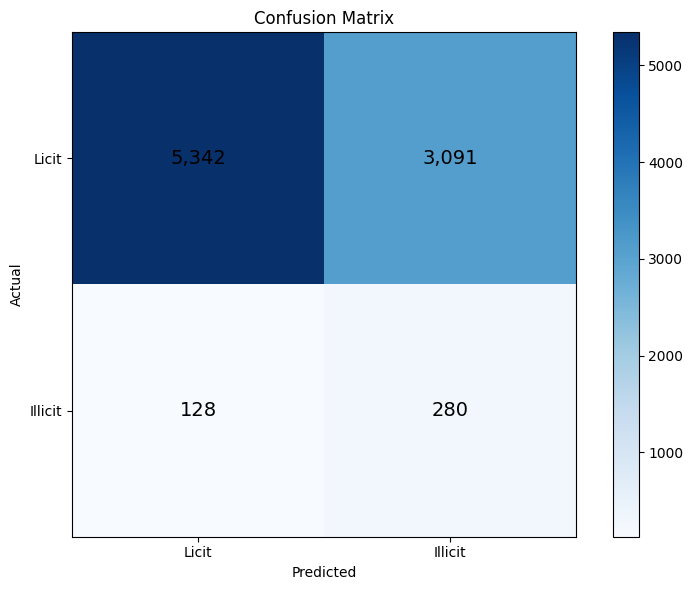

In [14]:
# Confusion Matrix
cm = confusion_matrix(test_metrics['y_true'], test_metrics['y_pred'])

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, cmap='Blues')

# Labels
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Licit', 'Illicit'])
ax.set_yticklabels(['Licit', 'Illicit'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')

# Annotate
for i in range(2):
    for j in range(2):
        text = ax.text(j, i, f'{cm[i, j]:,}', ha='center', va='center', fontsize=14)

plt.colorbar(im)
plt.tight_layout()
plt.show()

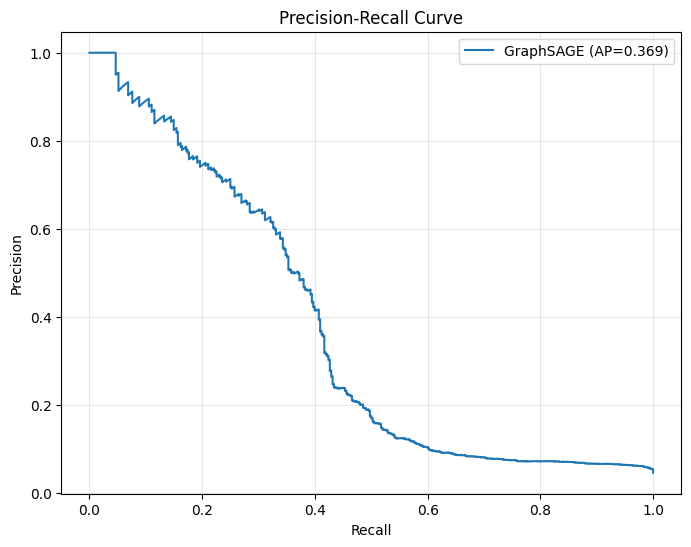

In [15]:
# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds = precision_recall_curve(
    test_metrics['y_true'], 
    test_metrics['y_prob']
)
ap = average_precision_score(test_metrics['y_true'], test_metrics['y_prob'])

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'GraphSAGE (AP={ap:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 8. Save Model Checkpoint

In [16]:
import os

# Create checkpoints directory
checkpoint_dir = '../baseline/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Save model checkpoint
checkpoint = {
    'model_state_dict': best_model_state,
    'model_config': {
        'num_features': data.num_node_features,
        'num_classes': 2,
        'hidden_dims': [256, 128],
        'embedding_dim': 64,
        'dropout': 0.3
    },
    'metrics': {
        'test_f1': test_metrics['f1'],
        'test_auc': test_metrics['auc']
    },
    'class_weights': class_weights.cpu().numpy()
}

checkpoint_path = os.path.join(checkpoint_dir, 'graphsage_baseline.pt')
torch.save(checkpoint, checkpoint_path)
print(f"Model saved to: {checkpoint_path}")

Model saved to: ../baseline/checkpoints/graphsage_baseline.pt


## 9. Generate Embeddings for Case Memory

Extract embeddings for all labeled nodes to build the case memory and FAISS index.

In [17]:
@torch.no_grad()
def get_all_embeddings(model, data):
    """Extract embeddings and predictions for all nodes."""
    model.eval()
    logits, embeddings = model(data.x, data.edge_index)
    probs = F.softmax(logits, dim=1)
    
    return {
        'embeddings': embeddings.cpu().numpy(),
        'fraud_scores': probs[:, 1].cpu().numpy(),
        'predictions': logits.argmax(dim=1).cpu().numpy(),
        'labels': data.y.cpu().numpy()
    }

results = get_all_embeddings(model, data)

print(f"Embeddings shape: {results['embeddings'].shape}")
print(f"Fraud scores range: [{results['fraud_scores'].min():.4f}, {results['fraud_scores'].max():.4f}]")

Embeddings shape: (203769, 64)
Fraud scores range: [0.0000, 0.9998]


In [18]:
# Save embeddings for case memory building
embeddings_path = os.path.join(checkpoint_dir, 'node_embeddings.npz')

np.savez(
    embeddings_path,
    embeddings=results['embeddings'],
    fraud_scores=results['fraud_scores'],
    predictions=results['predictions'],
    labels=results['labels']
)

print(f"Embeddings saved to: {embeddings_path}")

Embeddings saved to: ../baseline/checkpoints/node_embeddings.npz


## 10. Summary & Next Steps

### Results Summary

In [20]:
report = classification_report(test_metrics['y_true'], test_metrics['y_pred'], target_names=['Licit', 'Illicit'], output_dict=True)

print("=" * 60)
print("BASELINE MODEL SUMMARY")
print("=" * 60)
print(f"\nModel: GraphSAGE")
print(f"Architecture: 166 → 256 → 128 → 64 → 2")
print(f"\nTest Metrics:")
print(f"  • F1 Score (Illicit):  {test_metrics['f1']:.4f}")
print(f"  • AUC-ROC:             {test_metrics['auc']:.4f}")
print(f"  • Precision (Illicit): {report['Illicit']['precision']:.4f}")
print(f"  • Recall (Illicit):    {report['Illicit']['recall']:.4f}")
print(f"\nArtifacts saved:")
print(f"  • Model checkpoint: {checkpoint_path}")
print(f"  • Node embeddings:  {embeddings_path}")
print(f"\n" + "=" * 60)
print("NEXT STEPS")
print("=" * 60)
print("1. Build Case Memory from embeddings")
print("2. Create FAISS index for similarity search")
print("3. Test RAG pipeline with ICL prompts")
print("4. Integrate with LLM for explainable predictions")

BASELINE MODEL SUMMARY

Model: GraphSAGE
Architecture: 166 → 256 → 128 → 64 → 2

Test Metrics:
  • F1 Score (Illicit):  0.1482
  • AUC-ROC:             0.7717
  • Precision (Illicit): 0.0831
  • Recall (Illicit):    0.6863

Artifacts saved:
  • Model checkpoint: ../baseline/checkpoints/graphsage_baseline.pt
  • Node embeddings:  ../baseline/checkpoints/node_embeddings.npz

NEXT STEPS
1. Build Case Memory from embeddings
2. Create FAISS index for similarity search
3. Test RAG pipeline with ICL prompts
4. Integrate with LLM for explainable predictions
